In [36]:
import nltk
from nltk.corpus import reuters
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import numpy as np
import pandas as pd
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import accuracy_score , classification_report,confusion_matrix
from nltk.corpus import stopwords
import re
import string  
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
#trying to understand the dataset 
reuters.readme()

'\n      The Reuters-21578 benchmark corpus, ApteMod version\n\nThis is a publically available version of the well-known Reuters-21578\n"ApteMod" corpus for text categorization.  It has been used in\npublications like these:\n\n * Yiming Yang and X. Liu. "A re-examination of text categorization\n   methods".  1999.  Proceedings of 22nd Annual International SIGIR.\n   http://citeseer.nj.nec.com/yang99reexamination.html\n\n * Thorsten Joachims. "Text categorization with support vector\n   machines: learning with many relevant features".  1998. Proceedings\n   of ECML-98, 10th European Conference on Machine Learning.\n   http://citeseer.nj.nec.com/joachims98text.html\n\nApteMod is a collection of 10,788 documents from the Reuters financial\nnewswire service, partitioned into a training set with 7769 documents\nand a test set with 3019 documents.  The total size of the corpus is\nabout 43 MB.  It is also available for download from\nhttp://kdd.ics.uci.edu/databases/reuters21578/reuters2157

In [4]:
# List the raw text of the first 5 articles. 
for i in range(5):
    print('Article #' + str(i+1))
    print(reuters.raw(reuters.fileids()[i]))

Article #1
ASIAN EXPORTERS FEAR DAMAGE FROM U.S.-JAPAN RIFT
  Mounting trade friction between the
  U.S. And Japan has raised fears among many of Asia's exporting
  nations that the row could inflict far-reaching economic
  damage, businessmen and officials said.
      They told Reuter correspondents in Asian capitals a U.S.
  Move against Japan might boost protectionist sentiment in the
  U.S. And lead to curbs on American imports of their products.
      But some exporters said that while the conflict would hurt
  them in the long-run, in the short-term Tokyo's loss might be
  their gain.
      The U.S. Has said it will impose 300 mln dlrs of tariffs on
  imports of Japanese electronics goods on April 17, in
  retaliation for Japan's alleged failure to stick to a pact not
  to sell semiconductors on world markets at below cost.
      Unofficial Japanese estimates put the impact of the tariffs
  at 10 billion dlrs and spokesmen for major electronics firms
  said they would virtually h

# Represent train and test docs

In [8]:
# #extracting train and test documents 
# train_docs = list(filter(lambda doc: doc.startswith("train"),
#                         reuters.fileids()));
# test_docs = list(filter(lambda doc: doc.startswith("test"),
#                         reuters.fileids()));

In [12]:
#extracting train and test documents 
train_documents, train_categories = zip(*[(reuters.raw(i), reuters.categories(i))
for i in reuters.fileids() if i.startswith('training/')])
test_documents, test_categories = zip(*[(reuters.raw(i), reuters.categories(i))
for i in reuters.fileids() if i.startswith('test/')])

In [13]:
print('Number of docs in the train set:' + str(len(train_documents)))
print('Number of docs in the test set: ' + str(len(test_documents)))

Number of docs in the train set:7769
Number of docs in the test set: 3019


# Cleaning text


In [14]:
   
codes = ['\r', '\n', '\t','lt']
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower() #Make text lowercase
    text = re.sub('\[.*?\]', '',str(text))
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text)) #remove punctuation
    text = re.sub('\w*\d\w*', '', str(text)) #remove words containing numbers
    text = re.sub('[‘’“”…]', '', str(text))
    text = re.sub(r'dlrs', 'dollar', text)  # replace dlrs abreviation 
    text = re.sub(r'pct', 'percent', text)  # replace pct abreviation  
    for code in codes:
        text = re.sub(code, ' ', text)  # get rid of escape codes
    text = re.sub('\s+', ' ', text) # replace multiple spacess with one space   
    return text
    

In [16]:
#invoking the cleaning function to the training docs
cleaned_train_documents = []
for i in range(0,len(train_documents)):    
    cleaned_train_documents.append(clean_text(str(train_documents[i])))

In [17]:
#invoking the cleaning function to the testing docs
cleaned_test_documents = []
for i in range(0,len(test_documents)):
    cleaned_test_documents.append(clean_text(str(test_documents[i])))

# Tokenization


In [18]:
lemmatizer = WordNetLemmatizer()

def toknize(text):
    stop_words = set(stopwords.words("english"))
    tokens = word_tokenize(text) #split document into individual words(tokens)
    tokens= [word for word in tokens if word not in stop_words] #filter out stop words if requested
    tokens = [word for word in tokens if word.isalpha()] #remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if len(word) > 2] #filter out tokens that are one or two characters long
    tokens = [word for word in tokens if len(word) < 21] # filter out tokens that are more than twenty characters long
    lemmas= [lemmatizer.lemmatize(word) for word in tokens] #apply word lemmatization
    # recreate the document string from parsed words
    text = ''
    for lema in lemmas:
        text = text + ' ' + lema
    return tokens,text

In [19]:
train_text = [] # list of document strings for sklearn TF-IDF
train_tokens = []  # list of token lists
for doc in cleaned_train_documents:
    text_string = doc
    # parse words one at a time in document string
    tokens,text_string = toknize(text_string)
    train_tokens.append(tokens)
    train_text.append(text_string)


In [20]:
print('\nNumber of training documents:',len(train_text))
print('\nFirst item after text preprocessing, train_text[0]\n',train_text[0])
print('\nNumber of training token lists:',len(train_tokens))
print('\nFirst list of tokens after text preprocessing, train_tokens[0]\n',train_tokens[0])


Number of training documents: 7769

First item after text preprocessing, train_text[0]
  bahia cocoa review shower continued throughout week bahia cocoa zone alleviating drought since early january improving prospect coming temporao hough normal humidity level restored comissaria smith said weekly review dry period mean temporao late year arrival week ended february bag kilo making cumulative total season mln stage last year seems cocoa delivered earlier consignment included arrival figure comissaria smith said still doubt much old crop cocoa still available harvesting practically come end total bahia crop estimate around mln bag sale standing almost mln hundred thousand bag still hand farmer middleman exporter processor doubt much cocoa would fit export shipper experiencing dificu y obtaining bahia superior certificate view lower quality recent week farmer sold good part cocoa held consignment comissaria smith said spot bean price rose cruzados per arroba kilo bean shipper reluctant 

In [21]:
test_tokens = []  # list of token lists
test_text = [] # list of document strings for sklearn TF-IDF
for doc in cleaned_test_documents:
    text_string = doc
    # parse words one at a time in document string
    tokens,text_string = toknize(text_string)
    test_tokens.append(text_string)
    test_text.append(text_string)


# Exploratory Data Analysis (EDA)

### Counting The Number Of Words In The Corpus


In [22]:
indexes = [word for doc in train_tokens for word in doc]  
print(f"There are {len(indexes)} words in the data corpus")

There are 603572 words in the data corpus


### The top 50 most common words:

In [23]:
corpus_freq = Counter(indexes).most_common()
print(corpus_freq[:50])
print(len(corpus_freq))

[('said', 18838), ('mln', 13089), ('dollar', 9811), ('percent', 7398), ('cts', 5775), ('year', 5082), ('net', 4561), ('billion', 4104), ('loss', 4001), ('would', 3400), ('company', 2974), ('inc', 2894), ('shr', 2614), ('bank', 2587), ('last', 2393), ('trade', 2313), ('corp', 2301), ('oil', 2266), ('share', 2259), ('profit', 2243), ('market', 2030), ('new', 2010), ('one', 1925), ('stock', 1916), ('also', 1908), ('shares', 1895), ('tonnes', 1857), ('two', 1723), ('march', 1663), ('qtr', 1657), ('prices', 1649), ('sales', 1587), ('revs', 1565), ('per', 1513), ('february', 1511), ('january', 1484), ('april', 1459), ('group', 1419), ('may', 1355), ('first', 1345), ('rate', 1341), ('quarter', 1337), ('price', 1274), ('offer', 1256), ('exchange', 1184), ('agreement', 1126), ('government', 1126), ('foreign', 1101), ('japan', 1098), ('rose', 1095)]
27160


### How many words occur just once in the data set?


In [23]:
uniques = [word for word,freq in Counter(indexes).items() if freq == 1]
print(f"There are {len(uniques)} words that occur just once in the data corpus totaling 1638886 words")

There are 10697 words that occur just once in the data corpus totaling 1638886 words


### Number Of Words Without Duplication

In [25]:
unique_indexes = list(set(indexes))
print(f"There are {len(unique_indexes)} words in the data corpus that represent the vocabulary")

There are 27160 words in the data corpus that represent the vocabulary


### How often does each word occur?


In [24]:
vocabulary_df = pd.DataFrame(Counter(indexes).most_common(),columns=['words', 'num of words'])
vocabulary_df.head(10)

,words,num of words
0,said,18838
1,mln,13089
2,dollar,9811
3,percent,7398
4,cts,5775
5,year,5082
6,net,4561
7,billion,4104
8,loss,4001
9,would,3400


### How many words are in each document?


In [25]:
doc_sizes = ([len(lst) for lst in train_tokens]) # num of words in each document
print(f"Number of words in Rueters News Articles: {min(doc_sizes)} to {max(doc_sizes)}")
print(f"There are a total of {sum(doc_sizes)} words in the data corpus")

Number of words in Rueters News Articles: 0 to 807
There are a total of 603572 words in the data corpus


# Learn and transform train and test documents using tf-idf


In [28]:
# Learn and transform train documents
vectorizer = TfidfVectorizer(tokenizer=word_tokenize,max_df=0.95, min_df=3,max_features=1000)
vectorised_train_documents = vectorizer.fit_transform(train_text)
# transform test documents
vectorised_test_documents = vectorizer.transform(test_text)
train_feature_names= vectorizer.get_feature_names()

C:\Users\HP\anaconda_new\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [31]:
#transform the sparse matrix to dense matrix and creat Daraframe of feature space  
vectorised_train_documents_df= pd.DataFrame(vectorised_train_documents.todense(), columns = train_feature_names)
vectorised_train_documents_df.head()

,able,accept,accepted,accord,according,account,accounting,acquire,acquired,acquisition,...,year,yearago,yearonyear,yen,yesterday,yet,yeutter,yield,york,zealand
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.039583,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.35135,0.00000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.071301,0.0,0.0,...,0.033978,0.000000,0.00000,0.0,0.00000,0.0,0.0,0.0,0.00000,0.00000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.095733,0.000000,0.13972,0.0,0.00000,0.0,0.0,0.0,0.00000,0.13972
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.10364,0.0,0.0,0.0,0.00000,0.00000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.066271,0.181574,0.00000,0.0,0.00000,0.0,0.0,0.0,0.00000,0.00000


In [160]:
# for col in vectorised_train_documents.nonzero()[1]:# 1 means presenting the frequent of each term by the term 
#     print(train_feature_names[col], ' ',vectorised_train_documents[0,col])#tf-idf for first doc 

C:\Users\HP\anaconda_new\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


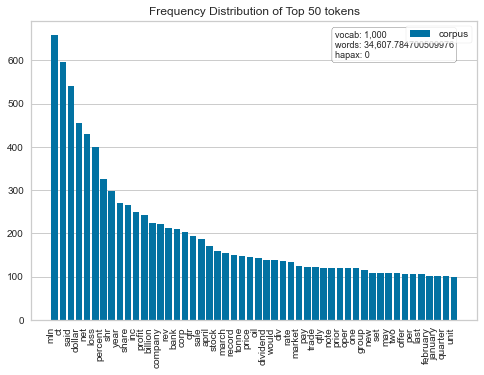

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [32]:
from yellowbrick.text import FreqDistVisualizer
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(vectorised_train_documents)
visualizer.show()

# Visualize the dataset with T-SNE

C:\Users\HP\anaconda_new\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\HP\anaconda_new\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


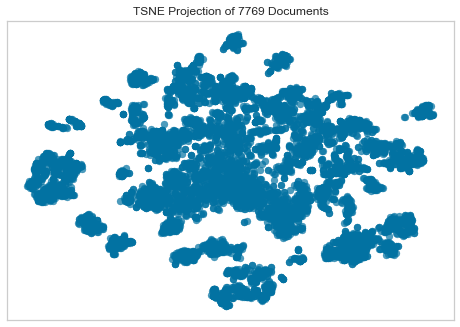

<AxesSubplot:title={'center':'TSNE Projection of 7769 Documents'}>

In [33]:
from yellowbrick.text import TSNEVisualizer
tsne = TSNEVisualizer()
tsne.fit(vectorised_train_documents)
tsne.show()

In [217]:
# from yellowbrick.text import UMAPVisualizer
# from sklearn.cluster import KMeans

# umap = UMAPVisualizer(metric="cosine")
# umap.fit(vectorised_train_documents)
# umap.show()

In [218]:
# from sklearn.decomposition import PCA

In [219]:
# pca_out = PCA(1000).fit(vectorised_train_documents_df)

In [220]:
# print(pca_out.explained_variance_ratio_)
# print(len(pca_out.explained_variance_ratio_))

In [221]:
# print(np.max((pca_out.components_)))
# print(pca_out.components_)
# print(type(pca_out.components_))

In [222]:
# print(np.sum(pca_out.explained_variance_))

In [223]:
# np.cumsum(pca_out.explained_variance_ratio_)


In [224]:
# loadings = pca_out.components_
# num_pc = pca_out.n_features_
# pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
# loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
# loadings_df['variable'] = vectorised_train_documents_df.columns.values
# loadings_df = loadings_df.set_index('variable')
# loadings_df

# Train and Evaluate Classifiers


In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss

ModelsPerformance = {}

def metricsReport(modelName, test_labels, predictions):
    accuracy = accuracy_score(test_labels, predictions)

    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + modelName + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
    ModelsPerformance[modelName] = micro_f1

# Transform Multilabel labels


In [37]:
#encode multi-label per instance 
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_categories)
test_labels = mlb.transform(test_categories)

In [38]:
mlb.classes_

array(['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa',
       'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn',
       'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk',
       'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut',
       'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt',
       'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead',
       'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx',
       'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr',
       'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel',
       'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil',
       'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship',
       'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean',
       'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed',
       'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', '

In [39]:
#Dataframe that represent labels per docs 
df_multilabel_train_data = pd.DataFrame(train_labels, columns=mlb.classes_)
# Viewing few rows of data
df_multilabel_train_data.head(10)

,acq,alum,barley,bop,carcass,castor-oil,cocoa,coconut,coconut-oil,coffee,...,sun-oil,sunseed,tea,tin,trade,veg-oil,wheat,wpi,yen,zinc
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [40]:
df_multilabel_test_data = pd.DataFrame(test_labels, columns=mlb.classes_)
# Viewing few rows of data
df_multilabel_test_data.head(10)

,acq,alum,barley,bop,carcass,castor-oil,cocoa,coconut,coconut-oil,coffee,...,sun-oil,sunseed,tea,tin,trade,veg-oil,wheat,wpi,yen,zinc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Random Forest Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier
rfClassifier = RandomForestClassifier(n_jobs=-1)
rfClassifier.fit(vectorised_train_documents, train_labels)
rfPreds = rfClassifier.predict(vectorised_test_documents)
metricsReport("Random Forest", test_labels, rfPreds)

------Random Forest Model Metrics-----
Accuracy: 0.7231
Hamming Loss: 0.0049
Precision:
  - Macro: 0.4082
  - Micro: 0.9537
Recall:
  - Macro: 0.1495
  - Micro: 0.6760
F1-measure:
  - Macro: 0.1966
  - Micro: 0.7912


C:\Users\HP\anaconda_new\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [233]:
# df=100
# ------Random Forest Model Metrics-----
# Accuracy: 0.7135
# Hamming Loss: 0.0051
# Precision:
#   - Macro: 0.3822
#   - Micro: 0.9529
# Recall:
#   - Macro: 0.1390
#   - Micro: 0.6653
# F1-measure:
#   - Macro: 0.1819
#   - Micro: 0.7836

In [234]:
# df=3
# ------Random Forest Model Metrics-----
# Accuracy: 0.6681
# Hamming Loss: 0.0057
# Precision:
#   - Macro: 0.4010
#   - Micro: 0.9625
# Recall:
#   - Macro: 0.1115
#   - Micro: 0.6095
# F1-measure:
#   - Macro: 0.1552
#   - Micro: 0.7464

In [235]:
# df=50
# ------Random Forest Model Metrics-----
# Accuracy: 0.7039
# Hamming Loss: 0.0052
# Precision:
#   - Macro: 0.3990
#   - Micro: 0.9559
# Recall:
#   - Macro: 0.1339
#   - Micro: 0.6541
# F1-measure:
#   - Macro: 0.1794
#   - Micro: 0.7767

# Decision Tree Classifier


In [42]:
from sklearn.tree import DecisionTreeClassifier

dtClassifier = DecisionTreeClassifier()
dtClassifier.fit(vectorised_train_documents, train_labels)
dtPreds = dtClassifier.predict(vectorised_test_documents)
metricsReport("Decision Tree", test_labels, dtPreds)

------Decision Tree Model Metrics-----
Accuracy: 0.7383
Hamming Loss: 0.0064
Precision:
  - Macro: 0.3860
  - Micro: 0.7839
Recall:
  - Macro: 0.3142
  - Micro: 0.7420
F1-measure:
  - Macro: 0.3360
  - Micro: 0.7623


C:\Users\HP\anaconda_new\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [238]:
# df=100
# ------Decision Tree Model Metrics-----
# Accuracy: 0.7188
# Hamming Loss: 0.0070
# Precision:
#   - Macro: 0.2939
#   - Micro: 0.7554
# Recall:
#   - Macro: 0.2672
#   - Micro: 0.7225
# F1-measure:
#   - Macro: 0.2722
#   - Micro: 0.7386

In [239]:
# df=3
# ------Decision Tree Model Metrics-----
# Accuracy: 0.7343
# Hamming Loss: 0.0064
# Precision:
#   - Macro: 0.4489
#   - Micro: 0.7849
# Recall:
#   - Macro: 0.3348
#   - Micro: 0.7417
# F1-measure:
#   - Macro: 0.3659
#   - Micro: 0.7627

In [240]:
# df=50
# ------Decision Tree Model Metrics-----
# Accuracy: 0.7304
# Hamming Loss: 0.0069
# Precision:
#   - Macro: 0.3416
#   - Micro: 0.7584
# Recall:
#   - Macro: 0.3080
#   - Micro: 0.7353
# F1-measure:
#   - Macro: 0.3102
#   - Micro: 0.7467

# Support Vector Machine Classifier 

In [43]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

svmClassifier = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svmClassifier.fit(vectorised_train_documents, train_labels)

svmPreds = svmClassifier.predict(vectorised_test_documents)
metricsReport("SVC Sq. Hinge Loss", test_labels, svmPreds)

------SVC Sq. Hinge Loss Model Metrics-----
Accuracy: 0.8009
Hamming Loss: 0.0036
Precision:
  - Macro: 0.5539
  - Micro: 0.9378
Recall:
  - Macro: 0.3319
  - Micro: 0.7935
F1-measure:
  - Macro: 0.3890
  - Micro: 0.8597


C:\Users\HP\anaconda_new\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [242]:
# df=100
# ------SVC Sq. Hinge Loss Model Metrics-----
# Accuracy: 0.7625
# Hamming Loss: 0.0042
# Precision:
#   - Macro: 0.4685
#   - Micro: 0.9288
# Recall:
#   - Macro: 0.2733
#   - Micro: 0.7527
# F1-measure:
#   - Macro: 0.3194
#   - Micro: 0.8315

In [243]:
# df=3
# ------SVC Sq. Hinge Loss Model Metrics-----
# Accuracy: 0.8135
# Hamming Loss: 0.0034
# Precision:
#   - Macro: 0.6478
#   - Micro: 0.9444
# Recall:
#   - Macro: 0.3994
#   - Micro: 0.8037
# F1-measure:
#   - Macro: 0.4701
#   - Micro: 0.8684

In [244]:
# df=50
# ------SVC Sq. Hinge Loss Model Metrics-----
# Accuracy: 0.7930
# Hamming Loss: 0.0038
# Precision:
#   - Macro: 0.5559
#   - Micro: 0.9365
# Recall:
#   - Macro: 0.3141
#   - Micro: 0.7794
# F1-measure:
#   - Macro: 0.3696
#   - Micro: 0.8507

In [245]:
# pip install scikit-multilearn

In [44]:
from skmultilearn.problem_transform import LabelPowerset

powerSetSVC = LabelPowerset(LinearSVC())
powerSetSVC.fit(vectorised_train_documents, train_labels)

powerSetSVCPreds = powerSetSVC.predict(vectorised_test_documents)
metricsReport("Power Set SVC", test_labels, powerSetSVCPreds)

------Power Set SVC Model Metrics-----
Accuracy: 0.8324
Hamming Loss: 0.0040
Precision:
  - Macro: 0.6072
  - Micro: 0.8896
Recall:
  - Macro: 0.4088
  - Micro: 0.8117
F1-measure:
  - Macro: 0.4624
  - Micro: 0.8489


C:\Users\HP\anaconda_new\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [247]:
# df=100
# ------Power Set SVC Model Metrics-----
# Accuracy: 0.8112
# Hamming Loss: 0.0046
# Precision:
#   - Macro: 0.5432
#   - Micro: 0.8656
# Recall:
#   - Macro: 0.3488
#   - Micro: 0.7847
# F1-measure:
#   - Macro: 0.3955
#   - Micro: 0.8232

In [248]:
# df=3
# ------Power Set SVC Model Metrics-----
# Accuracy: 0.8476
# Hamming Loss: 0.0035
# Precision:
#   - Macro: 0.6844
#   - Micro: 0.9065
# Recall:
#   - Macro: 0.4891
#   - Micro: 0.8288
# F1-measure:
#   - Macro: 0.5339
#   - Micro: 0.8659

In [249]:
# df=50
# ------Power Set SVC Model Metrics-----
# Accuracy: 0.8301
# Hamming Loss: 0.0041
# Precision:
#   - Macro: 0.5613
#   - Micro: 0.8842
# Recall:
#   - Macro: 0.3874
#   - Micro: 0.8053
# F1-measure:
#   - Macro: 0.4336
#   - Micro: 0.8429

# Naive Base Classifier

In [45]:
from sklearn.naive_bayes import MultinomialNB

nbClassifier = OneVsRestClassifier(MultinomialNB())
nbClassifier.fit(vectorised_train_documents, train_labels)

nbPreds = nbClassifier.predict(vectorised_test_documents)
metricsReport("Multinomial NB", test_labels, nbPreds)

------Multinomial NB Model Metrics-----
Accuracy: 0.6893
Hamming Loss: 0.0055
Precision:
  - Macro: 0.2440
  - Micro: 0.8916
Recall:
  - Macro: 0.1317
  - Micro: 0.6835
F1-measure:
  - Macro: 0.1499
  - Micro: 0.7738


C:\Users\HP\anaconda_new\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [251]:
# df=100
# ------Power Set SVC Model Metrics-----
# Accuracy: 0.8112
# Hamming Loss: 0.0046
# Precision:
#   - Macro: 0.5432
#   - Micro: 0.8656
# Recall:
#   - Macro: 0.3488
#   - Micro: 0.7847
# F1-measure:
#   - Macro: 0.3955
#   - Micro: 0.8232

In [252]:
# df=3
# ------Multinomial NB Model Metrics-----
# Accuracy: 0.5727
# Hamming Loss: 0.0071
# Precision:
#   - Macro: 0.1139
#   - Micro: 0.9758
# Recall:
#   - Macro: 0.0382
#   - Micro: 0.4952
# F1-measure:
#   - Macro: 0.0491
#   - Micro: 0.6570

In [253]:
# df=50
# ------Multinomial NB Model Metrics-----
# Accuracy: 0.6800
# Hamming Loss: 0.0057
# Precision:
#   - Macro: 0.1925
#   - Micro: 0.8965
# Recall:
#   - Macro: 0.1099
#   - Micro: 0.6595
# F1-measure:
#   - Macro: 0.1267
#   - Micro: 0.7599

In [46]:
print("  Model Name " + " "*10 + "| Micro-F1 Score")
print("-------------------------------------------")
for key, value in ModelsPerformance.items():
    print("  " + key, " "*(20-len(key)) + "|", value)
    print("-------------------------------------------")

  Model Name           | Micro-F1 Score
-------------------------------------------
  Random Forest        | 0.7911847452328853
-------------------------------------------
  Decision Tree        | 0.7623490669593854
-------------------------------------------
  SVC Sq. Hinge Loss   | 0.8596643518518519
-------------------------------------------
  Power Set SVC        | 0.8488826815642457
-------------------------------------------
  Multinomial NB       | 0.7738131236770487
-------------------------------------------
